# Predicting house sale prices using multiple linear regression

In [1]:
# importing relevant libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

### Introduction

The goal of this project is to use multiple linear regression to predict house sale prices using different house features. We are using a dataset with housing data from the city of Ames, Iowa, United States from 2006 to 2010. 

This is an expansion of a guided project from the **Data Scientist in Python** career path in Dataquest. The dataset was compiled by Dean De Cock and it's presented in this [article](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). Information about the columns can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

### Data extraction

Let's start by reading in the data and having a first look at it. 

In [2]:
houses = pd.read_csv('AmesHousing.txt', delimiter='\t')

In [3]:
houses.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
# how many rows and columns

houses.shape

(2930, 82)

In [5]:
# how many missing values in each column

pd.options.display.max_rows = None # make sure rows don't get cut when displayed
houses.isnull().sum().sort_values(ascending=False)

Pool QC            2917
Misc Feature       2824
Alley              2732
Fence              2358
Fireplace Qu       1422
Lot Frontage        490
Garage Qual         159
Garage Yr Blt       159
Garage Cond         159
Garage Finish       159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
BsmtFin Type 1       80
Bsmt Cond            80
Bsmt Qual            80
Mas Vnr Type         23
Mas Vnr Area         23
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Area           1
Garage Cars           1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Electrical            1
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
Roof Style            0
Year Remod/Add        0
Year Built            0
SalePrice             0
Overall Cond          0
Overall Qual          0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Area              0
Street                0
Lot Shape       

For this project, we are going to iteratively build and modify a pipeline of functions to process the data features, train and test our models. The idea is that, by doing so, we can clearly see how the performance of our model can improve as we change each of its functions.

Our pipeline is going to have 3 functions: `transform_features()`, `select_features()` and `train_and_test()`. We are going to start with a very simple version of these functions and gradually make them more complex. 

In [6]:
# simple pipeline function to streamline the 3 functions

def activate_pipeline(df):
    return(train_and_test(select_features(transform_features(df))))

### First iteration

For our first iteration, we won't do any feature transformation. To simplify, we'll just use one feature `Gr Liv Area` and we'll split the dataset 50-50 between training and test sets. The `train_and_test` function returns our error metric - RMSE (root mean squared error). The lower, the better. That way we can compare this results with that of the future iterations. 

In [7]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    df = df.copy() # make sure we don't modify the original df 
    np.random.seed(42) # set a random seed so that our results are reproducible
    df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe    
    train = df.iloc[:int(len(df) * .75)] # 75% of the data for the training set
    test = df.iloc[int(len(df) * .75):] 
    train_numeric = train.select_dtypes(include=['number'])
    test_numeric = test.select_dtypes(include=['number'])
    features = train_numeric.columns.drop('SalePrice')
    model = LinearRegression()
    model.fit(train_numeric[features], train['SalePrice'])
    predictions = model.predict(test_numeric[features])
    mse = mean_squared_error(predictions, test['SalePrice'])
    rmse = np.sqrt(mse)
    return(rmse)

In [8]:
activate_pipeline(houses)

56246.86068636533

### Second iteration: let's do some feature engineering!

This time, we are going to focus more on feature engineering. Before we modify our functions, we'll do some data exploring and cleaning. 

First we'll deal with null values. It's easier to visualize their importance by converting them into percentages. 

In [9]:
# calculate percentage of null values for each column

null_values_pct = (houses.isnull().sum() / houses.shape[0]).sort_values(ascending=False)

In [10]:
# remove from this list columns with no null values

null_values_pct = null_values_pct[null_values_pct != 0]

In [11]:
null_values_pct

Pool QC           0.995563
Misc Feature      0.963823
Alley             0.932423
Fence             0.804778
Fireplace Qu      0.485324
Lot Frontage      0.167235
Garage Qual       0.054266
Garage Yr Blt     0.054266
Garage Cond       0.054266
Garage Finish     0.054266
Garage Type       0.053584
Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
BsmtFin Type 1    0.027304
Bsmt Cond         0.027304
Bsmt Qual         0.027304
Mas Vnr Type      0.007850
Mas Vnr Area      0.007850
Bsmt Full Bath    0.000683
Bsmt Half Bath    0.000683
Garage Area       0.000341
Garage Cars       0.000341
Total Bsmt SF     0.000341
Bsmt Unf SF       0.000341
BsmtFin SF 2      0.000341
BsmtFin SF 1      0.000341
Electrical        0.000341
dtype: float64

Some columns have a very high percentage of null values. Before we decide if we want to drop or modify the columns with null values, we should have a look at the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) and see if these null values mean anything.

Indeed, by reading the documentation we can see that some of these null values do not represent real missing values. Instead, they mean the absence of something. That is, for the `Pool QC` ("pool quality") column, they mean the house has no pool;  for the `Garage Cond` ("garage condition") column they mean no garage, and so on. 

Null values in some other columns, however, really represent missing data. 

So we need to differentiate between those columns where null values actually represent a category (so we could just rename those null values as a category) and those where null values really mean missing data, in which case we need to decide what to do with those missing values.  

In [12]:
# list of columns with null values
null_values_pct.index

Index(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
       'Lot Frontage', 'Garage Qual', 'Garage Yr Blt', 'Garage Cond',
       'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Cond', 'Bsmt Qual', 'Mas Vnr Type',
       'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', 'Bsmt Unf SF', 'BsmtFin SF 2',
       'BsmtFin SF 1', 'Electrical'],
      dtype='object')

After checking the documentation, we've decided to do the following with the columns with null values:
- For most columns, null values seem to actually represent something like "the absence of" (see above for some examples). Some of these columns are categorical and others are numerical. For the categorical ones, we'll change the null values to `None`. As for the numerical ones, we'll replace them with a `0`.  
- The columns `Mas Vnr Type`, `Mas Vnr Area` (related to masonry veneer) already both have a category or value for "no veneer" (`None` and `0`, respectively), so in that case the NAs probably represent actual missing values. Since they are a very small percentage of the total values (less than 1%), we'll just replace them with the modes for the columns.
- We are going to remove the `Garage Yr Blt` column because its null values mean "no garage" but it's a continous variable and if we just replace the NAs with `0`, it would seem like the garage was built in year 0 or something. Since there are around 5% null values in that column, putting 0 could possibly distort the underlying data logic and confuse our model, so let's just remove the whole column. 
- Finally, the `Electrical` column has only one null value. Since it doesn't seem likely that it means "no electricity", we'll also replace that value with the mode. 

We'll make a copy of our dataset before we make any modifications, just to be safe.

In [13]:
houses_copy = houses.copy()

Let's start by addressing the "special cases", ie. the last three of the above list. That way, after we do that we can just replace all remaining null values in the dataframe with `None` and we are done.

In [14]:
houses_copy['Mas Vnr Type'] = houses_copy['Mas Vnr Type'].fillna(houses_copy['Mas Vnr Type'].mode()[0])

In [15]:
houses_copy['Mas Vnr Area'] = houses_copy['Mas Vnr Area'].fillna(houses_copy['Mas Vnr Area'].mode()[0])

In [16]:
houses_copy['Electrical'] = houses_copy['Electrical'].fillna(houses_copy['Electrical'].mode()[0]) 

In [17]:
for col in ['BsmtFin SF 1', 'BsmtFin SF 2',
            'Bsmt Unf SF', 'Total Bsmt SF',
            'Bsmt Full Bath', 'Bsmt Half Bath',
            'Garage Cars', 'Garage Area',
            'Lot Frontage']:
    houses_copy[col] = houses_copy[col].fillna(0)

In [18]:
houses_copy.drop(columns=['Garage Yr Blt'], inplace=True)

In [19]:
houses_copy.fillna("None", inplace=True)

Our model only works with numerical data, so we must make sure that all our features are numerical.

Let's have a look at all non-numerical columns to see what we can do. 

In [20]:
pd.options.display.max_columns = None # make sure we display all columns
houses_copy.select_dtypes(exclude=['number']).head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,TA,TA,CBlock,TA,Gd,Gd,BLQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Gd,Attchd,Fin,TA,TA,P,None,None,None,WD,Normal
1,RH,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,Gar2,WD,Normal
3,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,TA,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal
4,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal


These columns are categorical. We can change each of them into several dummy variables, one for each category, holding a 1 value when that variable corresponds to the right category and a 0 otherwise. 

Before we do that, let's check if there's any columns with numeric values that actually mean categorical values. By looking at the data documentation we can see that column `MS SubClass` has this problem. So we should change it to categorical before we change all categorical to dummies. 

In [21]:
houses_copy['MS SubClass'] = houses_copy['MS SubClass'].astype('category')

In [22]:
cat_cols = houses_copy.select_dtypes(exclude=['number']).columns

In [23]:
cat_cols

Index(['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating',
       'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')

In [24]:
houses_copy = pd.get_dummies(houses_copy, columns=cat_cols, prefix=cat_cols)

In [25]:
houses_copy.head()

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_None,Bsmt Qual_Po,Bsmt Qual_TA,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_None,Bsmt Cond_Po,Bsmt Cond_TA,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Exposure_None,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_None,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_None,BsmtFin Type 2_Re

In [26]:
houses_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Columns: 335 entries, Order to Sale Condition_Partial
dtypes: float64(10), int64(27), uint8(298)
memory usage: 1.7 MB


Everything seems in order! Now we only have numerical columns in the dataset. Now let's incorporate these processes into the updated functions of our pipeline. We are also going to remove the columns related to the house sale (like the date), since the goal is to predict the price by using the house features, and we can't know anything about the actual sale until it happens, so those columns don't make sense in our predictive model. Also, we'll get rid of `Order` and `PID`, since these are just index columns.

We are going to add the data cleaning processes we tried above to the `transform_features` function. The `select_features` function will be modified to return a dataframe with only the features the user selects. If no specific column is selected, the function will just return the entire dataframe. 

As for the `train_and_test()` function, we'll modify it so that it also returns the R2 value, besides the RMSE. That way, we have more information about our model's performance. 

In [27]:
def transform_features(df):
    df = df.copy()
    cols_to_drop = ['Mo Sold', 'Yr Sold', 
                    'Garage Yr Blt', 'Sale Condition',
                    'Order', 'PID', 'Sale Type'] 
    df.drop(columns=cols_to_drop, inplace=True)
    df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna(df['Mas Vnr Type'].mode()[0])
    df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(df['Mas Vnr Area'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    cols_na_to_0 = ['BsmtFin SF 1', 'BsmtFin SF 2',
                    'Bsmt Unf SF', 'Total Bsmt SF',
                    'Bsmt Full Bath', 'Bsmt Half Bath',
                    'Garage Cars', 'Garage Area',
                    'Lot Frontage'] 
    for col in cols_na_to_0:
        df[col] = df[col].fillna(0)
    df.fillna("None", inplace=True)
    df['MS SubClass'] = df['MS SubClass'].astype('category')
    cat_cols = df.select_dtypes(exclude=['number']).columns
    df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)
    return df

def select_features(df, features=None):
    if features:
        features.append('SalePrice')
        return df[features]
    else:
        return df

def train_and_test(df):
    np.random.seed(42) # set a random seed so that our results are reproducible
    df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe    
    train = df.iloc[:int(len(df) * .75)] # 75% of the data for the training set
    test = df.iloc[int(len(df) * .75):]   
    train_numeric = train.select_dtypes(include=['number'])
    test_numeric = test.select_dtypes(include=['number'])
    features = train_numeric.columns.drop('SalePrice')
    model = LinearRegression()
    model.fit(train_numeric[features], train['SalePrice'])
    predictions = model.predict(test_numeric[features])
    mse = mean_squared_error(predictions, test['SalePrice'])
    rmse = np.sqrt(mse)
    r2 = r2_score(predictions, test['SalePrice'])
    return(rmse, r2)

We also need to modify our pipeline function to accept the desired features as an input.

In [28]:
# simple pipeline function to streamline the 3 functions

def activate_pipeline(df, features=None):
    return(train_and_test(select_features(transform_features(df), features)))

In [29]:
activate_pipeline(houses)

(29545.485172108256, 0.8535088122861512)

Wow! We had a huge improvement, with our RMSE going down from 56246.86 in the earlier univariate model to 29545.48 from the multivariate version, improved by some feature engineering. 

The new version of our the `train_and_test()` function now also returns the R2 value - 0.8535 This basically means that around 85% of the variation in SalePrice is explained by our model, so that's not bad!

### Third iteration - introducing cross-validation

For our third iteration, we'll modify the our functions so that we can choose between different types of cross validation. 

We'll use a `k` parameter for that. If k is `None` (its default value), we perform the simple holdout validation we've been doing so far. When it's 2 or more, we do k-fold validation and return the average RMSE. 

In [30]:
def transform_features(df):
    df = df.copy()
    cols_to_drop = ['Mo Sold', 'Yr Sold', 
                    'Garage Yr Blt', 'Sale Condition',
                    'Order', 'PID', 'Sale Type'] 
    df.drop(columns=cols_to_drop, inplace=True)
    df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna(df['Mas Vnr Type'].mode()[0])
    df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(df['Mas Vnr Area'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    cols_na_to_0 = ['BsmtFin SF 1', 'BsmtFin SF 2',
                    'Bsmt Unf SF', 'Total Bsmt SF',
                    'Bsmt Full Bath', 'Bsmt Half Bath',
                    'Garage Cars', 'Garage Area',
                    'Lot Frontage'] 
    for col in cols_na_to_0:
        df[col] = df[col].fillna(0)
    df.fillna("None", inplace=True)
    df['MS SubClass'] = df['MS SubClass'].astype('category')
    cat_cols = df.select_dtypes(exclude=['number']).columns
    df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)
    return df

def select_features(df, features=None):
    if features:
        features.append('SalePrice')
        return df[features]
    else:
        return df

def train_and_test(df, k=None):
    np.random.seed(42) # set a random seed so that our results are reproducible
    df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe    
    features = df.columns.drop('SalePrice')
        
    if k is None:
        train = df.iloc[:int(len(df) * .75)] # 75% of the data for the training set
        test = df.iloc[int(len(df) * .75):]   
        train_numeric = train.select_dtypes(include=['number'])
        test_numeric = test.select_dtypes(include=['number'])
        model = LinearRegression()
        model.fit(train_numeric[features], train['SalePrice'])
        predictions = model.predict(test_numeric[features])
        mse = mean_squared_error(predictions, test['SalePrice'])
        rmse = np.sqrt(mse)
        return(rmse)
    
    if k > 1:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        model = LinearRegression()
        mses = cross_val_score(model, df[features], df['SalePrice'],  scoring='neg_mean_squared_error', cv=kf)
        avg_mse = -np.mean(mses)
        avg_rmse = np.sqrt(avg_mse)
        return(avg_rmse)
    
    

Now we also need to change our pipeline function so that it also accepts an optional `k` parameter. 

In [31]:
def activate_pipeline(df, features=None, k=None):
    return(train_and_test(select_features(transform_features(df), features), k))

Now let's try different values of k to see how the RMSE changes.

In [32]:
for k in range(2,11):
    print('\nk =', k)
    print('RMSE: ', activate_pipeline(houses, k=k))


k = 2
RMSE:  882205547.8445587

k = 3
RMSE:  308052499.20784295

k = 4
RMSE:  31797.395872831104

k = 5
RMSE:  31082.424695081136

k = 6
RMSE:  97636053.07057293

k = 7
RMSE:  135914156.35716018

k = 8
RMSE:  5142159.233204962

k = 9
RMSE:  42353299.7254899

k = 10
RMSE:  20760217.61188385


The RMSE results from k-fold cross validation are higher (ie. worse) than the one we got in the previous iteration. However, they might be more realistic. This is because with k-fold validation, we split the data into a k number of folds and then each fold gets the change to be used as the test set once and then we average the result. That way, we make sure our results are not too optimistic in case our model is overfitting the test set. We can also see that the optimal value for k seems to be 5, which is a common choice. 

### Final round: choosing best features

One thing we haven't done yet is choosing the best combinations of features and seeing how they perform. Fortunately, we can easily do that, since we have already added a feature that allows that to our functions in the second iteration. 

We can make a list of the features, ranked from the ones more highly correlated to `SalePrice` to the less correlated ones.  

In [33]:
features_by_corr = np.abs(transform_features(houses).corr()['SalePrice']).sort_values(ascending=False)[1:]

In [34]:
features_by_corr

Overall Qual            0.799262
Gr Liv Area             0.706780
Garage Cars             0.647562
Garage Area             0.640138
Total Bsmt SF           0.632529
1st Flr SF              0.621676
Bsmt Qual_Ex            0.593567
Exter Qual_TA           0.590897
Year Built              0.558426
Full Bath               0.545604
Kitchen Qual_Ex         0.537561
Year Remod/Add          0.532974
Kitchen Qual_TA         0.526721
Foundation_PConc        0.520966
Mas Vnr Area            0.502196
TotRms AbvGrd           0.495474
Fireplace Qu_None       0.481446
Exter Qual_Ex           0.480477
Fireplaces              0.474558
BsmtFin Type 1_GLQ      0.455326
Heating QC_Ex           0.454553
Bsmt Qual_TA            0.452487
Exter Qual_Gd           0.446489
Neighborhood_NridgHt    0.433299
BsmtFin SF 1            0.433147
Garage Finish_Fin       0.424902
Garage Finish_Unf       0.421876
Mas Vnr Type_None       0.394743
Fireplace Qu_Gd         0.371630
Garage Type_Detchd      0.365074
MS SubClas

Now let's try some models with different number of features and see how they go. We'll choose the top `n` features each time, according to our results above and using different values for `n` each time, going from 1 (just the top feature) to 336 (all features).  

In this experiment, we'll use a fixed value of 5 for `k`, which seemed to get good results above. 

In [35]:
n_values = range(1,337) 
rmses = []
for n in n_values:
    rmses.append(activate_pipeline(houses, features=list(features_by_corr.index[0:n]),k=5))

Let's put the results in a Series so we can have a look at it. 

In [36]:
results = pd.Series(index=n_values, data=rmses, name='number of features - RMSE')

In [37]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # avoid results being printed in scientific notation
results

1            48058.56197
2            41439.77278
3            39782.87576
4            39412.35503
5            37744.93302
6            37646.41434
7            35256.61710
8            34900.59160
9            34463.91205
10           34441.50502
11           33590.18786
12           33401.58622
13           33321.80855
14           33331.16138
15           33116.97495
16           33086.98881
17           32781.93251
18           32721.81384
19           32538.14904
20           32353.03385
21           32316.42126
22           32330.45535
23           32321.90604
24           32271.29477
25           32025.88751
26           32004.41498
27           32006.25342
28           31872.02100
29           31903.95912
30           31863.73891
31           31815.60458
32           31499.41366
33           31515.21130
34           31523.88278
35           31515.63238
36           31536.79389
37           31535.95306
38           31471.50372
39           31490.82692
40           31488.71155


We can see that the RMSE tends to go down as we increase the number of features, until we reach its lowest point with 143 features, then it starts to go up and oscilate until it reaches some really high and scary numbers. 

Let's plot it so we can visualize it better. We need to put a limit on the y-axis, otherwise the huge numbers will make the plot hard to understand. 

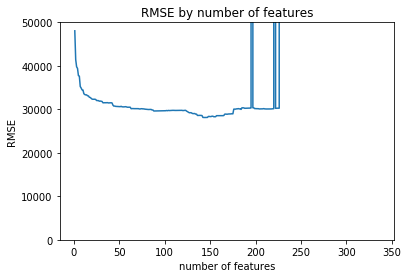

In [38]:
plt.plot(n_values, rmses)
plt.ylim(0, 50000)
plt.xlabel('number of features')
plt.ylabel('RMSE')
plt.title('RMSE by number of features')
plt.show()

Our top performing model, with 143 features, had a RMSE of around 28121.67. That's a great improvement from our first univariate model that had a RMSE value of approximately 56246.86. We could still keep improving the model with more feature engineering and using methods like regularization, but we'll leave it for now. 